In [1]:
%matplotlib inline
from __future__ import print_function
import os
import sys
sys.path.append("..")
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle as rect
import matplotlib.pyplot as plt
import pyemu

In [2]:
import freyberg_setup as fs
fs.setup_pest_pp()
pst_name = fs.PST_NAME_PP
working_dir = fs.WORKING_DIR_PP


changing model workspace...
   freyberg_pp
FloPy is using the following  executable to run the model: /Users/mnfienen/Documents/GIT/GW1876/activities/freyberg_pilot_points_advanced_monte_carlo/freyberg_pp/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.1.4 4/01/2018                         
                    BASED ON MODFLOW-2005 Version 1.12.0 02/03/2017                       

                    SWR1 Version 1.04.0 09/15/2016                       

 Using NAME file: freyberg.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/10/22  8:45:18

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Groundwater-Flow Eqn.
 Run end date and time (yyyy/

/Users/mnfienen/Documents/GIT/pyemu/pyemu/utils/gw_utils.py:1607: PyemuWarning: Flow out (flout) of grouped segments will be aggregated... 
  warnings.warn("Flow out (flout) of grouped segments will be aggregated... ", PyemuWarning)


writing 'sfr_obs.config' to sfr_obs.config
                                    obsnme     obsval  weight    obgnme
c001fr05c04_19791231  c001fr05c04_19791231  29.135645     0.0  forehead
c001fr16c17_19791231  c001fr16c17_19791231  21.775225     0.0  forehead
starting interp point loop for 800 points
took 2.946756 seconds
noptmax: 0
noptmax: 8


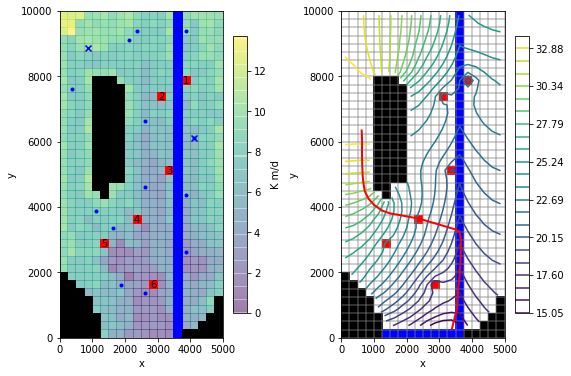

In [3]:
fs.plot_model(working_dir, pst_name)

## Advanced Monte Carlo

### In the previous pilot points Monte Carlo notebook, we saw that none of the realizations fit the observations anywhere close to ``phimlim`` because of the dimensionality of the pilot point problem.  

### Here, we will use so linear algebra trickeration to "pre-condition" the realizations so that they have a better chance of fitting the observations. As we all know now, "linear algebra" = Jacobian!

### First we need to run the calibration process to get the MAP parameters and last Jacobian

In [4]:
pst = pyemu.Pst(os.path.join(working_dir,pst_name))
# some control settings
pst.control_data.noptmax = 5
pst.pestpp_options["n_iter_base"] = -1
pst.pestpp_options["n_iter_super"] = 3
# adjust observation weights
#wl_obs = [o for o in pst.nnz_obs_names if o.startswith('c')]
#pst.observation_data.loc[wl_obs,"weight"] = 0.5
# Tikhonov regularization
pyemu.helpers.zero_order_tikhonov(pst,par_groups=["rch","w0","w1"])
v = pyemu.geostats.ExpVario(contribution=1.0,a=2500.0)
gs = pyemu.geostats.GeoStruct(variograms=v,nugget=0.0)
df_pp = pyemu.pp_utils.pp_tpl_to_dataframe(os.path.join(working_dir,"hkpp.dat.tpl"))
cov = gs.covariance_matrix(df_pp.x,df_pp.y,df_pp.parnme)
pyemu.helpers.first_order_pearson_tikhonov(pst,cov,reset=False)
pst.reg_data.phimlim = 500
pst.reg_data.phimaccept = 550
pst.control_data.pestmode = "regularization"
# subspace regularization
pst.svd_data.maxsing = 3
# save the control file and check it
pst.write(os.path.join(working_dir,pst_name))
pyemu.os_utils.run("pestchek {0}".format(pst_name),cwd=working_dir)


noptmax: 5


In [5]:
os.chdir(working_dir)
pyemu.os_utils.start_slaves('.',"pestpp",pst_name,num_slaves=15,master_dir='.')
os.chdir("..")

In [6]:
obs = pst.observation_data
obs.loc[pst.nnz_obs_names,:]

,obsnme,obsval,weight,obgnme,extra
obsnme,,,,,
c001cr03c10_19700102,c001cr03c10_19700102,26.262615,5.00,calhead,NaN
c001cr03c16_19700102,c001cr03c16_19700102,23.463532,5.00,calhead,NaN
c001cr04c09_19700102,c001cr04c09_19700102,28.126832,5.00,calhead,NaN
c001cr10c02_19700102,c001cr10c02_19700102,30.430534,5.00,calhead,NaN
c001cr14c11_19700102,c001cr14c11_19700102,25.442033,5.00,calhead,NaN
c001cr16c17_19700102,c001cr16c17_19700102,20.064206,5.00,calhead,NaN
c001cr22c11_19700102,c001cr22c11_19700102,24.333130,5.00,calhead,NaN
c001cr23c16_19700102,c001cr23c16_19700102,19.950425,5.00,calhead,NaN
c001cr25c05_19700102,c001cr25c05_19700102,24.844271,5.00,calhead,NaN


In [7]:
pst.phi

597.91909407911783

## How does this all pan out when we run the models?

Let's look at two options:  
1. unconstrained Monte Carlo (like we did before [bad things!])  
2. posterior sampling from the ``schur`` compliment 

### first, unconstrained

In [8]:
cov = pyemu.helpers.geostatistical_prior_builder(pst,{gs:df_pp},sigma_range=6)
mc = pyemu.MonteCarlo(jco=os.path.join(working_dir,pst_name.replace(".pst",".jco")),pst=pst,parcov=cov)
mc.pst.parrep(os.path.join(working_dir,pst_name.replace(".pst",".parb")))
mc.draw(num_reals=500, enforce_bounds="reset",how='gaussian')
mc.parensemble.to_csv(os.path.join(working_dir,"sweep_in.unconst.csv"))
pst.pestpp_options["sweep_output_csv_file"] = "sweep_out.unconst.csv"
pst.pestpp_options["sweep_parameter_csv_file"] = "sweep_in.unconst.csv"
pst.write(os.path.join(working_dir,pst_name))

making full cov draws with home-grown goodness
noptmax: 5


In [9]:
os.chdir(working_dir)
pyemu.os_utils.start_slaves('.','pestpp-swp',pst_name,num_slaves=15,master_dir='.')
os.chdir("..")

### now with the ```schur``` bayesian monte carlo

Here, we will swap out the prior parameter covariance matrix ($\boldsymbol{\Sigma}_{\theta}$) for the FOSM-based posterior parameter covariance matrix ($\overline{\boldsymbol{\Sigma}}_{\theta}$).  Everything else is exactly the same (sounds like a NIN song)

In [10]:
sc = pyemu.Schur(jco=os.path.join(working_dir,pst_name.replace(".pst",".jcb")),pst=pst,parcov=cov)
sc.pst.parrep(os.path.join(working_dir,pst_name.replace(".pst",".parb")))
mc = pyemu.MonteCarlo(pst=pst,parcov=sc.posterior_parameter)
mc.draw(num_reals=500, enforce_bounds="reset",how='gaussian')
mc.parensemble.to_csv(os.path.join(working_dir,"sweep_in.schur.csv"))
pst.pestpp_options["sweep_output_csv_file"] = "sweep_out.schur.csv"
pst.pestpp_options["sweep_parameter_csv_file"] = "sweep_in.schur.csv"
pst.write(os.path.join(working_dir,pst_name))
os.chdir(working_dir)
pyemu.os_utils.start_slaves('.',"pestpp-swp",pst_name,num_slaves=15,master_dir='.')
os.chdir("..")

making full cov draws with home-grown goodness
noptmax: 5


unconstrained good enough:0
schur good enough:181


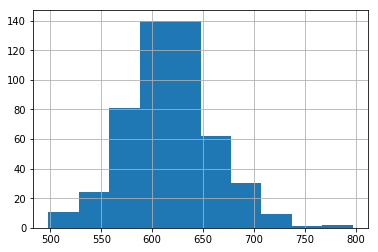

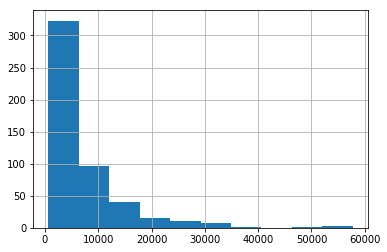

In [11]:
df_unconst = pd.read_csv(os.path.join(working_dir,"sweep_out.unconst.csv"))
df_unconst.columns = [c.lower() for c in df_unconst.columns]
df_schur = pd.read_csv(os.path.join(working_dir,"sweep_out.schur.csv"))
df_schur.columns = [c.lower() for c in df_schur.columns]

acceptable_phi = 600
ge_schur = df_schur.loc[df_schur.phi<acceptable_phi].index.values
ge_unconst = df_unconst.loc[df_unconst.phi<acceptable_phi].index.values
print("unconstrained good enough:{0}".format(len(ge_unconst)))    
print("schur good enough:{0}".format(len(ge_schur))) 
df_schur.phi.hist(bins=10)
plt.show()
df_unconst.phi.hist(bins=10)

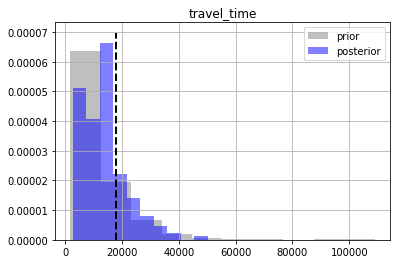

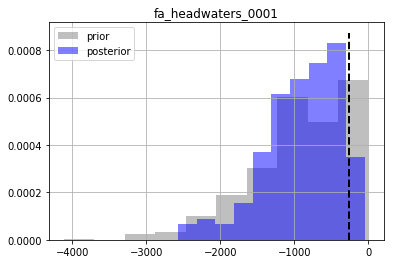

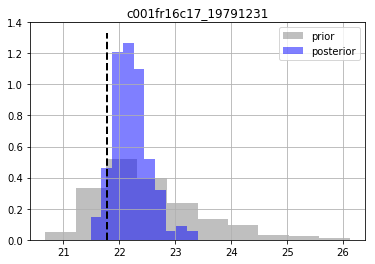

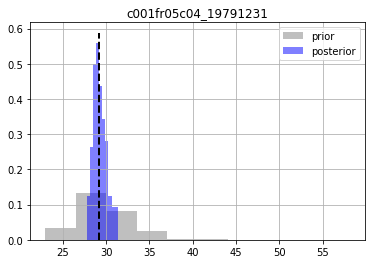

In [12]:
for forecast in mc.pst.forecast_names:
    ax = plt.subplot(111)
    df_unconst.loc[:,forecast].hist(ax=ax,bins=10,alpha=0.5,color="0.5",normed=True,label="prior") 
    df_schur.loc[ge_schur,forecast].hist(ax=ax,bins=10,alpha=0.5,color="b",normed=True,label="posterior")    
    ylim = ax.get_ylim()
    v = mc.pst.observation_data.loc[forecast,"obsval"]
    ax.plot([v,v],ylim,"k--",lw=2.0)
    ax.set_title(forecast)
    ax.legend()
    plt.show()